In [ ]:
FOLDERPATH = r'E:\PhD\EEG_data\Pareidolia_BIDS'
FREQ_BANDS = [[1, 3], [3, 7], [7, 12], [12, 20],[20, 30], [30, 45], [45, 60]]
FREQ_NAMES = ['delta', 'theta', 'alpha', 'low-beta', 'high-beta', 'gamma1', 'gamma2']
RUN_LIST = {'pareidolia':['1', '2', '3', '4']}
SUBJ_LIST = ['01']
TASK_LIST = ['pareidolia']
frontal_L = ['E20', 'E21', 'E22', 'E23', 'E24', 'E26', 'E27', 'E12', 'E18', 'E19', 'E11', 'E15', 'E16']
frontal_R = ['E2', 'E3', 'E4', 'E5', 'E118', 'E124', 'E123', 'E9', 'E10', 'E14', 'E11', 'E15', 'E16']
frontal_LR = frontal_L+frontal_R
occi_R = ['E76', 'E83', 'E84']
occi_L = ['E66', 'E70', 'E71']

In [ ]:
import mne
from mne.datasets.brainstorm import bst_raw
from mne.time_frequency import tfr_morlet, psd_multitaper, psd_welch
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
import scipy.io as sio

import pandas as pd
import scipy.io as sio
from scipy.io import savemat, loadmat
from EEG_pareidolia_utils import get_pareidolia_bids, reformat_events
from biotuner_utils import *
from biotuner_offline import *
from biotuner import *

In [ ]:
epochs = mne.read_epochs('../../pareidolia_run4.fif')
epochs = epochs.apply_baseline((-1.5, -0.1))
#epochs = epochs.crop(tmin, tmax)
epochs_data = epochs.get_data()

In [ ]:
peaks

In [ ]:
#This function is used to compute peak values for each frequency bands on evoked data
def compute_peaks_EMD(EMD, condition, chs, FREQ_BANDS, dim_reduc = 'avg', tmin = None, tmax = None, precision = 0.125, sf = 1000):
    import functools
    import pandas as pd
    #epochs are cropped as desire (tmin could be before '0', ex: -1.5, depending on the values used during epoching)
    epochs = epochs.apply_baseline((-1.5, -0.1))
    epochs = epochs.crop(tmin, tmax)
    print(epochs.get_data().shape)
    EOG_chs = ['E1', 'E8', 'E25', 'E32', 'E126', 'E127']
    Unwanted = ['E43', 'E48', 'E49', 'E128', 'E113', 'E120', 'E125', 'E119', 'E129']
    All_chs = epochs.info['ch_names'][0:129]
    EEG_chs = [ele for ele in All_chs if ele not in Unwanted]
    EEG_chs = [ele for ele in EEG_chs if ele not in EOG_chs]
    #Find number of samples
    n_samples = len(epochs.get_data()[0][0])-1
    print(n_samples)
    precision = precision/(sf/n_samples)
    fft_size = int(n_samples/precision)
    #Average across trials for specific condition
    evoked = epochs[condition].average(chs)
    FREQs_temp2 = []
    #This loop iterates for each epoch
    for min, max in FREQ_BANDS:
        FREQs_temp = []
        #psds, freqs = function(epochs[t], fmin=min, fmax=max, bandwidth = 4, picks = EEG_chs)  #PSDs are calculated with this function, giving power values and corresponding frequency bins as output
        psds, freqs = psd_welch(evoked, fmin=min, fmax=max, n_fft = fft_size)
        psds = 10. * np.log10(psds)   #PSDs values are transformed in log scale to compensate for the 1/f natural slope
        for ch in range(len(psds)):
            index_max = np.argmax(np.array(psds[ch][:]))
            freq = freqs[index_max]
            print(index_max) # Should not be zero in all bands (would signify strong 1/f trend)
            FREQs_temp.append(freq)
        if dim_reduc =='avg':
            FREQs_avg = np.average(FREQs_temp)
            FREQs_temp2.append(FREQs_avg)
        if dim_reduc =='mode':
            s = pd.Series(FREQs_temp)
            FREQs_mode = s[s.duplicated()].unique().tolist()
            import itertools
            
            FREQs_temp2.append(FREQs_mode)
            print(FREQs_temp2)
    if dim_reduc =='avg':
        FREQs_temp2 = [round(num, 1) for num in FREQs_temp2]
    if dim_reduc =='mode':
        FREQs_temp2 = list(itertools.chain(*FREQs_temp2))
    FREQs = np.array(FREQs_temp2)
    return FREQs

In [63]:
par = ['Image_on_par_high', 'Image_on_par_mid', 'Image_on_par_low']
nopar = ['Image_on_nopar_high', 'Image_on_nopar_mid', 'Image_on_nopar_low']
condition = par
chs = frontal_LR
dim_reduc = 'mode' #Mode could either be 'avg' or 'mode'
precision = 0.25   #Default precision is 0.125Hz
peaks= compute_peaks_avg(epochs.copy(), condition, chs, FREQ_BANDS, dim_reduc = dim_reduc, tmin = 0, tmax = 8, precision = precision, sf =1000)
peaks

Applying baseline correction (mode: mean)


/home/ubuntu/BioTuning/CoCoBrainChannel/Python/biotuner_offline.py:55: RuntimeWarning: Cropping removes baseline period, setting epochs.baseline = None
  epochs = epochs.crop(tmin, tmax)


(84, 114, 8001)
8000
Effective window size : 4.000 (s)
0
0
0
0
0
1
7
0
0
1
0
0
0
0
0
0
0
0
0
0
0
1
0
[[1.0, 1.25]]
Effective window size : 4.000 (s)
0
5
11
11
8
8
11
11
8
4
8
11
11
11
0
0
2
2
0
2
12
0
12
[[1.0, 1.25], [5.75, 5.0, 3.0, 3.5, 6.0]]
Effective window size : 4.000 (s)
6
9
9
4
9
9
19
19
2
9
4
4
0
0
3
5
5
5
6
5
9
6
9
[[1.0, 1.25], [5.75, 5.0, 3.0, 3.5, 6.0], [9.25, 11.75, 8.0, 7.0, 8.25, 8.5]]
Effective window size : 4.000 (s)
9
25
4
4
19
12
4
12
27
32
4
4
30
8
32
2
4
13
4
13
20
6
6
[[1.0, 1.25], [5.75, 5.0, 3.0, 3.5, 6.0], [9.25, 11.75, 8.0, 7.0, 8.25, 8.5], [13.0, 15.0, 20.0, 15.25, 13.5]]
Effective window size : 4.000 (s)
40
35
35
35
35
35
35
0
40
25
25
25
0
0
36
34
34
0
34
0
35
7
3
[[1.0, 1.25], [5.75, 5.0, 3.0, 3.5, 6.0], [9.25, 11.75, 8.0, 7.0, 8.25, 8.5], [13.0, 15.0, 20.0, 15.25, 13.5], [28.75, 30.0, 26.25, 20.0, 28.5]]
Effective window size : 4.000 (s)
5
5
5
5
5
5
5
5
5
16
10
3
9
6
22
9
24
9
24
39
5
5
10
[[1.0, 1.25], [5.75, 5.0, 3.0, 3.5, 6.0], [9.25, 11.75, 8.0, 7.0

array([ 1.  ,  1.25,  5.75,  5.  ,  3.  ,  3.5 ,  6.  ,  9.25, 11.75,
        8.  ,  7.  ,  8.25,  8.5 , 13.  , 15.  , 20.  , 15.25, 13.5 ,
       28.75, 30.  , 26.25, 20.  , 28.5 , 31.25, 32.25, 36.  , 32.5 ,
       45.25, 52.25, 47.75])

In [53]:
from ipywidgets import interact
import ipywidgets as widgets
import matplotlib.pyplot as plt
import numpy as np
from scipy.signal import argrelmin
import dissonant as D
from dissonant import harmonic_tone, dissonance, pitch_to_freq

freqs, amps = harmonic_tone(pitch_to_freq([0, 2.5, 7, 12]), n_partials=10)
dis = dissonance(freqs, amps, model='sethares1993')
dis

def freq_space(base_f=440, octaves=4, steps=1000):
    ratios = np.linspace(1, octaves, steps)
    freqs = base_f * ratios
    return freqs

def dissonance_curve(freq_space, n_partials=10, model='sethares1993'):
    dissonances = []
    for freq in freq_space:
        h_freqs, h_amps = D.harmonic_tone([freq_space[0], freq], n_partials=n_partials)
        #print(h_amps)
        d = D.dissonance(h_freqs, h_amps, model=model)
        dissonances.append(d)
    dissonances = np.array(dissonances)
    return dissonances

def plot_dissonance_curve(freqs, dissonances):
    minima = argrelmin(dissonances)[0]

    plt.figure(figsize=(16, 3))
    plt.xlim(freqs[0], freqs[-1])
    plt.plot(freqs, dissonances)
    for m in minima:
        plt.axvline(freqs[m], c='r', ls=':')
    plt.xlabel('frequency')
    plt.ylabel('dissonance')
    
def diss_curve_minima(freqs, n_partials = 100, mult = 1000):
    for f in range(len(freqs)):
        freqs[f] = freqs[f]*mult
    print(np.min(freqs))
    freq_min = np.min(freqs)
    dissonance = dissonance_curve(freqs, n_partials=n_partials, model='sethares1993')
    minima = argrelmin(dissonance)[0]
    freqs_cons = []
    freqs_diss_value = []
    cons_ratios = []
    for m in minima:
        freqs_cons.append(freqs[m])
        freqs_diss_value.append(dissonance[m])
        cons_ratios.append((freqs[m])/freq_min)
    freqs_cons = [x for _,x in sorted(zip(freqs_diss_value,freqs_cons))]
    return freqs_cons, cons_ratios

def rebound(x, low = 1, high = 2, octave = 2):
    while x > high:
        x = x/octave
    while x < low:
        x = x*octave
    return x

In [64]:
freqs = sorted(peaks)
#freq = 500 * [1, 2, 3, 4, 5, 6]
cons_freqs, cons_ratios = diss_curve_minima(freqs, mult = 100)

#for c in range(len(cons_freqs)):
#    cons_freqs[c] = rebound(cons_freqs[c])

print(cons_freqs, cons_ratios)

100.0
[3225.0, 3000.0, 1500.0, 1300.0, 800.0, 500.0, 300.0] [3.0, 5.0, 8.0, 13.0, 15.0, 30.0, 32.25]


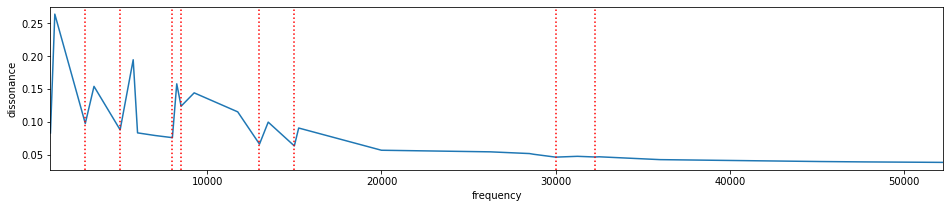

In [65]:
#freqs = sorted(peaks)
for f in range(len(freqs)):
        freqs[f] = freqs[f]*10
plot_dissonance_curve(freqs, dissonance_curve(freqs, n_partials=100, model='sethares1993'))

In [ ]:
to_sort = psds[0][88][:]
sorted(range(len(to_sort)), key=lambda k: to_sort[k])

## Outside of MNE

In [ ]:
epochs['Image_on_par_high'].plot_psd(picks = EEG_chs, fmin=30, fmax =45)

In [ ]:
epochs_frontal_nopar = epochs['Image_on_nopar_high', 'Image_on_nopar_mid', 'Image_on_nopar_low'].average(frontal_LR)
epochs_frontal_par = epochs['Image_on_par_high', 'Image_on_par_mid', 'Image_on_par_low'].average(frontal_LR)
epochs_occi_par = epochs.average(occi_L)
epochs_occi_nopar = epochs['Image_on_nopar_high', 'Image_on_nopar_mid', 'Image_on_nopar_low'].average(occi_L)


In [ ]:
frontal_data = np.average(epochs_occi_par.data, axis = 0)

In [ ]:
epochs_frontal_par_detrend = epochs_frontal_par.detrend()

In [ ]:
import scipy
fs = 1000
nfft = 4000
steps = fs/nfft
f, pxx = scipy.signal.welch(frontal_data, fs = fs, nfft = nfft)
pxx = scipy.signal.detrend(pxx)

In [ ]:
delta = [1, 3]
delta_low = int(delta[0]/steps)
delta_high = int(delta[1]/steps)
theta = [3, 7]
theta_low = int(theta[0]/steps)
theta_high = int(theta[1]/steps)
alpha = [7, 12]
alpha_low = int(alpha[0]/steps)
alpha_high = int(alpha[1]/steps)
SMR = [12, 20]
SMR_low = int(SMR[0]/steps)
SMR_high = int(SMR[1]/steps)
hibeta = [20, 30]
hibeta_low = int(hibeta[0]/steps)
hibeta_high = int(hibeta[1]/steps)
gamma1 = [30, 45]
gamma1_low = int(gamma1[0]/steps)
gamma1_high = int(gamma1[1]/steps)
gamma2 = [45, 60]
gamma2_low = int(gamma2[0]/steps)
gamma2_high = int(gamma2[1]/steps)



delta_power = pxx[delta_low:delta_high]
theta_power = pxx[theta_low:theta_high]
alpha_power = pxx[alpha_low:alpha_high]
SMR_power = pxx[SMR_low:SMR_high]
hibeta_power = pxx[hibeta_low:hibeta_high]
gamma1_power = pxx[gamma1_low:gamma1_high]
gamma2_power = pxx[gamma2_low:gamma2_high]

In [ ]:
plt.plot(gamma2_power)

In [ ]:
#for i in range(len(psds[0][0])):
index_max = np.argmax(np.array(to_sort))   
index_max

In [ ]:
to_sort = gamma1_power
sorted(range(len(to_sort)), key=lambda k: to_sort[k])

In [ ]:
test

In [ ]:
for subj in SUBJ_LIST:
    for task in TASK_LIST:
        for run in RUN_LIST[task]:
            epochs_name, epochs_path = get_pareidolia_bids(FOLDERPATH, subj, task, run, stage = 'epo_long_AR_pnp', cond=None)
            epochs = mne.read_epochs(epochs_path)
            #Si vous voulez comparer les epochs entières (8sec), il est mieux de laisser de côté le début et la fin des epochs.
            psds_welch= compute_psd(epochs, FREQ_BANDS, psd_multitaper, tmin = 0.1, tmax = 7.9)
            #le nom du stage doit commencer par PSD, la fin du nom est à votre choix
            psds_file, psds_path = get_pareidolia_bids(FOLDERPATH, subj, task, run, stage = 'PSD_long_AR_pnp')
            savemat(psds_path, {'PSD': psds_welch})